<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/005_TensorFlow_Proj_Five_CNN_KerasTuner_LaEterna_Clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [ ]:
# keras-tuner
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
# utils
import os, warnings
import pandas as pd
import numpy as np
# colab
from google.colab import drive
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import (Input, Lambda, Dense,
                                     Flatten, Dropout, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import (image, image_dataset_from_directory)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
# kerastuner
from kerastuner.tuners import RandomSearch
# vis
import matplotlib.pyplot as plt

<ipython-input-3-6dfadf042270>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# GPU
physical_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
print("No. GPUs available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

No. GPUs available:  0


In [ ]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/DataSets/LaEterna/")

In [ ]:
print(os.getcwd())
print(os.listdir())

/content/drive/MyDrive/DataSets/LaEterna
['.DS_Store', 'Train', 'Test', 'submission_file.csv']


## Convolutional Neural Net

In [ ]:
# set the seeds value for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [ ]:
# image dataset
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2,
                                     shear_range =.25, zoom_range =.2,
                                     horizontal_flip = True, rotation_range=20)
# train and validation split
train_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='./Train',
                                                 shuffle=True,
                                                 target_size=(224, 224),
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=32,
                                                 directory='./Train',
                                                 shuffle=True,
                                                 target_size=(224, 224),
                                                 subset="validation",
                                                 class_mode='categorical')
# organize data for our predictions
image_generator_submission = ImageDataGenerator(rescale=1/255)
submission = image_generator_submission.flow_from_directory(
                                                 directory='./Test',
                                                 shuffle=False,
                                                 target_size=(224, 224),
                                                 class_mode=None)

Found 430 images belonging to 2 classes.
Found 106 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


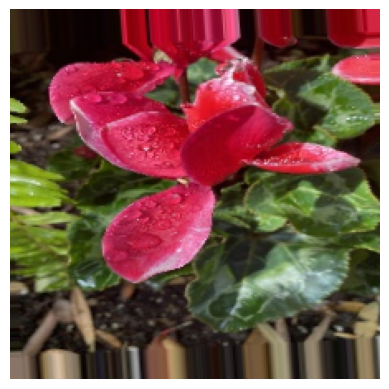

In [ ]:
# show flowers for the first batch
batch_one_img = train_dataset[0]
for i in range(0,1): # batch_size is equal to 32 so 1 should change to 32 in practice
    img = batch_one_img[0][i]
    lab = batch_one_img[1][i]
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# convolutional neural net
model = keras.models.Sequential(
    [
        keras.layers.Conv2D(32, 3, activation='relu',
                            input_shape = [224, 224,3]),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation ='softmax')
    ]
    )
# compile
model.compile(loss = 'binary_crossentropy',optimizer='adam',
              metrics = ['accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)
# fit
model.fit(train_dataset, epochs=1, validation_data=validation_dataset, callbacks=callback)
# evaluate
loss, accuracy = model.evaluate(validation_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 154s 7s/step - accuracy: 0.5842 - loss: 1.0998 - val_accuracy: 0.8208 - val_loss: 0.5183
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8502 - loss: 0.5012
Loss: 0.5214151740074158
Accuracy: 0.8207547068595886


In [ ]:
# Prediction
pred = model.predict(submission)
# print(pred.round())

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step


In [24]:
# data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal", input_shape=(224,224,3)),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    ]
    )
model_aug = Sequential([data_augmentation, model])
model_aug.compile(loss = 'binary_crossentropy',optimizer='adam',
                  metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)
model_aug.fit(train_dataset, epochs=3, validation_data=validation_dataset,
              callbacks=callback)

Epoch 1/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8267 - loss: 0.0000e+00 - val_accuracy: 0.8774 - val_loss: 0.0000e+00
Epoch 2/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.8487 - loss: 0.0000e+00 - val_accuracy: 0.9623 - val_loss: 0.0000e+00
Epoch 3/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8983 - loss: 0.0000e+00 - val_accuracy: 0.8962 - val_loss: 0.0000e+00


In [27]:
model_aug.metrics_names

['loss', 'loss', 'compile_metrics', 'compile_metrics']

In [29]:
_, loss, _, accuracy = model_aug.evaluate(validation_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)
# model_aug.predict(submission).round()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - accuracy: 0.8812 - loss: 0.0000e+00
Loss: 0.0
Accuracy: 0.8773584961891174


In [30]:
# data prep
final_data = []
final_labels = []

for i in range(0,len(train_dataset)):
    batch = train_dataset[i]
    for j in range(len(batch[0])):
        final_data.append(batch[0][j])
        final_labels.append(batch[1][j])

val_data = []
val_labels = []

for i in range(0,len(validation_dataset)):
    batch = validation_dataset[i]
    for j in range(len(batch[0])):
        val_data.append(batch[0][j])
        val_labels.append(batch[1][j])

final_data = np.array(final_data)
final_labels = np.array(final_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)

In [31]:
# tune params
def build_model(hp):
    model = keras.Sequential([data_augmentation])
    model.add(keras.layers.AveragePooling2D(4,2))
    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
        model.add(keras.layers.MaxPool2D((3,3)))
    # model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256]), activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    )

tuner.search(final_data, final_labels, validation_data=(val_data, val_labels), epochs=2)

Trial 4 Complete [00h 00m 38s]
val_loss: 0.5345867872238159

Best val_loss So Far: 0.5034034848213196
Total elapsed time: 00h 02m 26s


In [32]:
# best model
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 111, 111, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 109, 109, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,655,042 (10.13 MB)

 Trainable params: 2,655,042 (10.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
onlyfiles = [f.split('.')[0] for f in os.listdir(os.path.join('Test/images')) if os.path.isfile(os.path.join(os.path.join('Test/images'), f))]
submission_df = pd.DataFrame(onlyfiles, columns =['images'])
submission_df[['la_eterna','other_flower']] = best_model.predict(submission)
submission_df.head()
submission_df.to_csv('submission_file.csv', index = False)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
